In [1]:
import numpy as np 
import nibabel as nib 
import matplotlib.pyplot as plt 
import nilearn.plotting as niplt
%matplotlib inline 
import os 
import seaborn as sns 
from scipy.special import softmax 
import pandas as pd 

In [2]:
black_subs=['sub-300', 'sub-304', 'sub-293', 'sub-273', 'sub-265', 'sub-307', 'sub-283', 'sub-275', 
'sub-291', 'sub-297', 'sub-303', 'sub-294', 'sub-286', 'sub-282', 'sub-310', 'sub-302', 'sub-312', 
'sub-301', 'sub-287', 'sub-298', 'sub-313', 'sub-285', 'sub-292', 'sub-311', 'sub-267', 'sub-295', 
'sub-305', 'sub-274', 'sub-290', 'sub-288', 'sub-281', 'sub-276', 'sub-277', 'sub-299', 'sub-308',
 'sub-272', 'sub-284', 'sub-289', 'sub-280', 'sub-309', 'sub-306', 'sub-127', 'sub-279', 
 'sub-315', 'sub-314']
slumlordreach_subs=['sub-145', 'sub-143', 'sub-016', 'sub-142', 'sub-141', 'sub-133', 'sub-140', 'sub-136', 
'sub-084', 'sub-135', 'sub-137', 'sub-138', 'sub-111', 'sub-106', 'sub-134', 'sub-132', 'sub-144']

def get_result_dataset(dataset,rep_name,normalize_isc=True):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        if 'layer' not in rep_name and 'ling' not in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+story+"_"+rep_name+"/"
        else:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
        for sub in subs:
            results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')
            results_sub=np.zeros((22,))
            noise_sub=np.zeros((22,))
            
            for roi in range(22):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
                noise_sub[roi]=noise_ceiling_parcels[np.where(roi_mapping==roi+1)].mean()
            #results_story.append(-1*np.log(results_sub/noise_sub))
            if normalize_isc:
                r=(results_sub/noise_sub)*100.0 
                r[r>100.0]=100.0
                results_story.append((results_sub/noise_sub)*100.0)
            else:
                results_story.append((results_sub))
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    results=np.concatenate(results,axis=0)
    results[np.isnan(results)]=0.0
    return results 
def get_result_dataset_total(dataset,rep_name):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        if 'layer' not in rep_name and 'ling' not in rep_name and 'z' not in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+story+"_"+rep_name+"/"
        else:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
        for sub in subs:
            results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            results_story.append((results_sub_parcels))
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    results=np.concatenate(results,axis=0)
    results[np.isnan(results)]=0.0
    return results 
    #return results*-1
    #if normalize_isc:
    #    return (np.concatenate(results,axis=0)/noise_ceiling)*100.0
    #else:
    #    return np.concatenate(results,axis=0)

In [3]:
layerwise=np.mean(np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_activations") for i in range(12)]),axis=1)
zwise=np.mean(np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_z_representations") for i in range(12)]),axis=1)

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [6]:
layers_total=np.asarray([get_result_dataset_total(['black','slumlordreach'],'layer_'+str(i)+"_activations") for i in range(12)]).mean(axis=1)
z_total=np.asarray([get_result_dataset_total(['black','slumlordreach'],'layer_'+str(i)+"_z_representations") for i in range(12)]).mean(axis=1)
parcellation_nii=nib.load('/jukebox/griffiths/bert-brains/black_data/Schaefer1000_3mm.nii.gz')
parcellation=parcellation_nii.get_fdata().astype('int')
layers_volumes=[np.zeros(parcellation.shape) for _ in range(12)]
z_volumes=[np.zeros(parcellation.shape) for _ in range(12)]
for layer in range(12):
    print(layer)
    for p in range(1000):
        layers_volumes[layer][np.where(parcellation==p+1)]=layers_total[layer,p]
        z_volumes[layer][np.where(parcellation==p+1)]=z_total[layer,p]
layers_final_volume=np.zeros((parcellation.shape)+(12,))
z_final_volume=np.zeros((parcellation.shape)+(12,))
for j in range(12):
    layers_final_volume[:,:,:,j]=layers_volumes[j]
    z_final_volume[:,:,:,j]=z_volumes[j]
affine=parcellation_nii.affine 
print(np.array_equal(layers_final_volume,z_final_volume))
nib.save(nib.Nifti1Image(layers_final_volume,affine),'/jukebox/griffiths/bert-brains/results/average_performance_layers.nii')
nib.save(nib.Nifti1Image(z_final_volume,affine),'/jukebox/griffiths/bert-brains/results/average_performance_z.nii')

0
1
2
3
4
5
6
7
8
9
10
11
False


In [4]:
layers_total=np.asarray([get_result_dataset_total(['black','slumlordreach'],'layer_'+str(i)+"_activations") for i in range(12)])
z_total=np.asarray([get_result_dataset_total(['black','slumlordreach'],'layer_'+str(i)+"_z_representations") for i in range(12)])
layers_total.shape

(12, 62, 1000)

In [5]:
layers_pvalues=np.zeros((12,1000))
z_pvalues=np.zeros((12,1000))
def bootstrap_pvalue(data):
    boots=[]
    original=data.mean()
    data=data-data.mean()
    for _ in range(1000):
        samp=np.concatenate([np.random.choice(data[:46],size=46,replace=True),np.random.choice(data[46:],size=17,replace=True)])
        boots.append(samp.mean()>=original)
    boots=np.asarray(boots)
    if np.sum(boots)==0:
        return 1.0/1000
    else:
        return np.sum(boots)/1000.0
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig] 

for i in range(12):
    print(i)
    for j in range(1000):
        layers_pvalues[i,j]=bootstrap_pvalue(layers_total[i,:,j])
        z_pvalues[i,j]=bootstrap_pvalue(z_total[i,:,j])
layers_pvalues=p_adjust_bh(layers_pvalues.flatten()).reshape(layers_pvalues.shape)
z_pvalues=p_adjust_bh(z_pvalues.flatten()).reshape(z_pvalues.shape)

0


In [34]:
np.sum(layers_pvalues>0)/np.prod(layers_pvalues.shape) 

1.0

In [29]:

layers_volumes=[np.zeros(parcellation.shape) for _ in range(12)]
z_volumes=[np.zeros(parcellation.shape) for _ in range(12)]
for layer in range(12):
    print(layer)
    for p in range(1000):
        layers_volumes[layer][np.where(parcellation==p+1)]=layers_pvalues[layer,p]
        z_volumes[layer][np.where(parcellation==p+1)]=z_pvalues[layer,p]

layers_final_volume=np.zeros((parcellation.shape)+(12,))
z_final_volume=np.zeros((parcellation.shape)+(12,))
for j in range(12):
    layers_final_volume[:,:,:,j]=layers_volumes[j]
    z_final_volume[:,:,:,j]=z_volumes[j]
affine=parcellation_nii.affine 
print(np.array_equal(layers_final_volume,z_final_volume))
nib.save(nib.Nifti1Image(layers_final_volume,affine),'/jukebox/griffiths/bert-brains/results/pvalues_layers.nii')
nib.save(nib.Nifti1Image(z_final_volume,affine),'/jukebox/griffiths/bert-brains/results/pvalues_z.nii')

0
1
2
3
4
5
6
7
8
9
10
11
False


In [12]:
story='black'
x=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
y=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')

np.where(x==20)[0],np.where(y==21)[0]

(array([649, 650, 652, 653]), array([649, 650, 652, 653]))

In [5]:
rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC','HG','V1']
#rois=['HG','PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC']

roi_names=['L_'+roi for roi in rois]+['R_'+roi for roi in rois] 

def softmax(x, tau=1.0):
    e_x = np.exp(x / tau)
    return e_x / e_x.sum()

def make_df(data,smax=True,tau=1.0,n_points=1000):
    x=[]
    g=[]
    
    for roi in range(11,22):
        if smax:
            p=softmax(data[:,roi],tau=tau)
        else:
            p=data[:,roi].copy()
            p[p<0]=0.0
            p/=np.sum(p)
            p[np.isnan(p)]=0.0
            if np.sum(p)==0.0:
                p[:]=1.0/len(p)
       
        points=np.random.choice(np.arange(12),size=n_points,p=p)
        for p in points:
            x.append(p)
            g.append(roi_names[roi])
    x=np.asarray(x)
    g=np.asarray(g)
    #g = np.tile(roi_names, n_points)
    df = pd.DataFrame(dict(x=x, g=g))
    return df 
def make_ridge_plot(data,n_points=10000,tau=1.0,smax=True,bw_adjust=2):
    df=make_df(data,smax=smax,tau=tau,n_points=n_points)
    #m = df.g.map(ord)
    #df["x"] += m
    # Initialize the FacetGrid object
    #pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    pal=sns.mpl_palette('tab10',n_colors=10)
    g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "x",
        bw_adjust=bw_adjust, clip_on=False,
        fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=bw_adjust)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .9, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "x")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.0009)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(xticks=list(range(0,13)))
    g.set(yticks=[]) 
    g.despine(bottom=True, left=True)



    

In [15]:
x=[]
g=[]
l=[]
v=[]
for roi in range(11):
    p=softmax(layerwise[:,roi],tau=1) 
    p2=softmax(zwise[:,roi],tau=1)
    #points=np.random.choice(np.arange(12),size=10000,p=p)
    #points2=np.random.choice(np.arange(12),size=10000,p=p2)
    points_val=[]
    points2_val=[]
    
    points=[]
    points2=[]
    for i in range(len(p)):
        points.append(np.ones((int(p[i]*10000),))*i)
        points2.append(np.ones((int(p2[i]*10000),))*i)
    points=np.concatenate(points)
    points2=np.concatenate(points2)
    sz=min(len(points2),len(points))
    for i in range(len(points)):
        v.append(p[points[i].astype('int')])
        x.append(points[i])
        g.append(roi_names[roi])
        l.append("A")
    for i in range(len(points2)):
        v.append(p2[points2[i].astype('int')])
        x.append(points2[i])
        g.append(roi_names[roi])
        l.append("B")
x=np.asarray(x)
g=np.asarray(g)
v=np.asarray(v)
#g = np.tile(roi_names, n_points)
df = pd.DataFrame(dict(x=x,g=g,l=l,v=v))

pal2[0]

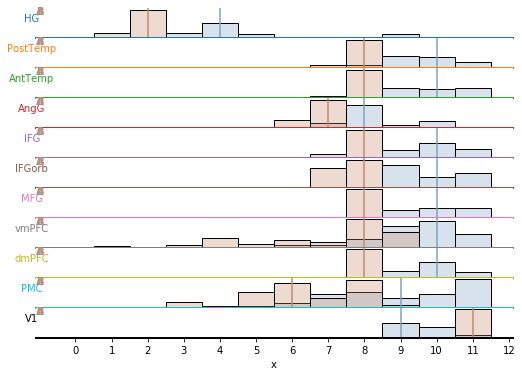

In [16]:
shuffle_labels=[0,5,7,9,3,5,1,2,4,6,8,10]
order=np.asarray(['L_'+x for x in ['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1']])

colors=list(sns.mpl_palette('tab10',n_colors=10).as_hex())+['#000000']
pal=sns.color_palette(np.asarray(colors))
pal2=sns.mpl_palette('twilight_shifted',n_colors=2)
g = sns.FacetGrid(df, row="g", hue="l", aspect=15, height=0.5, palette=pal2,row_order=order,sharey=False,sharex=True)


g.map(sns.histplot, "x", discrete=True,alpha=0.3)
#g.map(sns.histplot, "x",kde=True)
#g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=2)
#g.map(plt.axhline, y=0, lw=2, clip_on=False,color=pal)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .9, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

#g.set_axis_labels("")
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.0009)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(xticks=list(range(0,13)))
g.set(yticks=[]) 
g.despine(bottom=True, left=True)
for i in range(11):
    roi_name=order[i][2:]
    ii=rois.index(roi_name)
    p=softmax(layerwise[:,ii],tau=1) 
    p2=softmax(zwise[:,ii],tau=1)
    points=[]
    points2=[]
    for j in range(len(p)):
        points.append(np.ones((int(p[j]*10000),))*j)
        points2.append(np.ones((int(p2[j]*10000),))*j)
    points=np.concatenate(points)
    points2=np.concatenate(points2)
    g.axes[i,0].axvline(x=np.median(points),color=pal2[0])
    g.axes[i,0].axvline(x=np.median(points2),color=pal2[1])
    g.axes[i,0].set_ylabel(order[i%11][2:],rotation=0)
    g.axes[i,0].yaxis.label.set_color(pal[i%11])
    g.axes[i,0].axhline(y=0,lw=2,clip_on=False,color=pal[i%11])
    g.axes[i]
     
#plt.savefig('plots/fig2_1/left_hemi_gpt_ridge_bars.svg',format='svg')

2.0

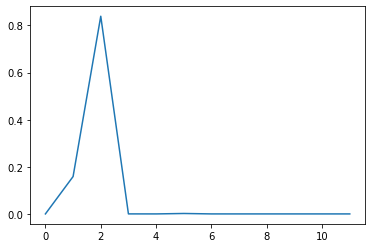

In [25]:
i=9
p=softmax(layerwise[:,i],tau=1) 
p2=softmax(zwise[:,i],tau=1)
points=[]
points2=[]
for j in range(len(p)):
    points.append(np.ones((int(p[j]*10000),))*j)
    points2.append(np.ones((int(p2[j]*10000),))*j)
points=np.concatenate(points)
points2=np.concatenate(points2)
plt.plot(p2)
np.median(points2)

In [104]:
layer_entropies[16]

array([5.38307098e-01, 1.48293720e+00, 1.47539766e-02, 9.48972381e-01,
       1.61123251e-01, 5.28684711e-01, 6.12888981e-02, 3.83323074e-01,
       1.06555297e-04, 8.39136472e-01, 4.92449427e-02, 1.81913856e+00,
       1.25921449e+00, 1.67732828e-01, 3.47595456e-01, 1.43480875e-01,
       1.08384784e+00, 2.43885507e-02, 1.83622304e+00, 2.26140039e+00,
       1.41764142e+00, 9.87089391e-01, 1.20391974e+00, 1.10782285e+00,
       1.04775640e+00, 1.86603809e-01, 1.70109025e+00, 1.04186661e+00,
       1.07926255e+00, 1.13768220e-03, 7.27949508e-01, 1.00388922e+00,
       3.48614212e-02, 9.35860745e-04, 9.53815328e-01, 7.07564834e-05,
       1.13165441e-02, 2.06466983e+00, 1.13293345e+00, 1.12189253e+00,
       5.60365388e-01,            nan, 1.19059208e-01, 2.25209157e-03,
       1.31776798e-01, 6.49219183e-01, 2.18291278e+00, 7.38890305e-01,
       1.84864367e+00, 1.59902807e+00, 3.00074016e-01, 1.15036505e+00,
       1.85881084e+00, 1.76032435e+00, 1.52271817e+00, 2.32853381e-01,
      

In [11]:
layerwise.shape

(12, 63, 20)

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Difference in Layerwise vs Transformation Entropy')

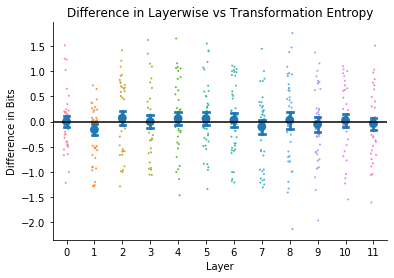

In [13]:
def entropy(ps):
    logged=np.log2(ps)
    logged[np.isnan(logged)]=0.0
    return -np.sum(ps*np.log2(ps))
layerwise=np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_activations") for i in range(12)])
zwise=np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_z_representations") for i in range(12)])
layer_entropies=np.zeros((12,63))
z_entropies=np.zeros((12,63))
for i in range(12):
    for j in range(63):
        layer_entropies[i,j]=entropy(softmax(layerwise[i,j,10:],tau=1.0))
        z_entropies[i,j]=entropy(softmax(zwise[i,j,10:],tau=1.0))
layer_entropies[np.isnan(layer_entropies)]=0.0
z_entropies[np.isnan(z_entropies)]=0.0

roi=[]
performance=[]
for i in range(layer_entropies.shape[0]):
    for j in range(layer_entropies.shape[1]):
        roi.append(i)
        r=layer_entropies[i,j]-z_entropies[i,j]
        performance.append(r)
roi=np.asarray(roi)
performance=np.asarray(performance)
hemi=np.asarray(hemi)
df=pd.DataFrame(dict(performance=performance,roi=roi))

pal=sns.mpl_palette('tab10',n_colors=10)
#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
sns.stripplot(data=df,x='roi',y='performance',dodge=0.4,zorder=1,size=2)
sns.pointplot(data=df,x='roi',y='performance',dodge=0.4,join=False,ci=95,n_boot=10000,capsize=0.2,zorder=2,alpha=0.5)
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)
plt.xticks()
#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
sns.despine(top=True,right=True,left=False,bottom=False)
plt.xlabel("Layer")
plt.ylabel("Difference in Bits")
plt.title("Difference in Layerwise vs Transformation Entropy")



In [19]:
def entropy(ps):
    logged=np.log2(ps)
    logged[np.isnan(logged)]=0.0
    return -np.sum(ps*logged)
layerwise=np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_activations") for i in range(12)])
zwise=np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_z_representations") for i in range(12)])
layer_entropies=np.zeros((20,63))
z_entropies=np.zeros((20,63))
for i in range(20):
    for j in range(63):
        layer_entropies[i,j]=entropy(softmax(layerwise[:,j,i],tau=1.0))
        z_entropies[i,j]=entropy(softmax(zwise[:,j,i],tau=1.0))
layer_entropies[np.isnan(layer_entropies)]=0.0
z_entropies[np.isnan(z_entropies)]=0.0

rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC','HG']
raw_data=np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_activations") for i in range(12)])
#raw_data=np.mean(np.asarray([raw_data[:,:,:10],raw_data[:,:,10:]]),axis=0)
roi=[]
performance=[]
hemi=[]
for i in range(layer_entropies.shape[0]):
    for j in range(layer_entropies.shape[1]):
        roi.append(rois[i%10])
        hemi.append('L' if i<10 else 'R')
        r=layer_entropies[i,j]-z_entropies[i,j]
        performance.append(r)
roi=np.asarray(roi)
performance=np.asarray(performance)
hemi=np.asarray(hemi)
df=pd.DataFrame(dict(performance=performance,roi=roi,hemi=hemi))


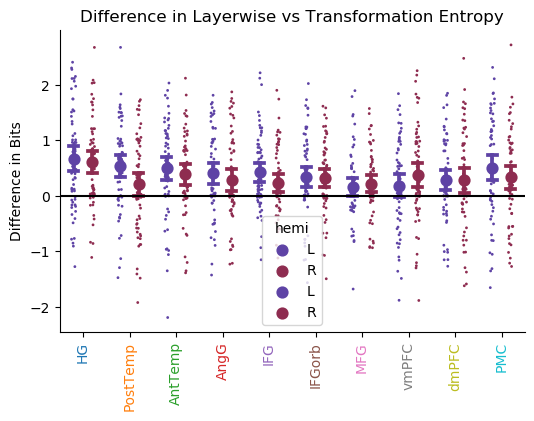

In [20]:
pal=sns.mpl_palette('tab10',n_colors=10)
pal2=sns.mpl_palette('twilight',n_colors=2)
plt.figure(dpi=100)
#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
sns.stripplot(data=df,x='roi',y='performance',hue='hemi',dodge=0.4,zorder=1,size=2,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC'])
sns.pointplot(data=df,x='roi',y='performance',hue='hemi',dodge=0.4,join=False,ci=95,n_boot=10000,capsize=0.2,zorder=2,alpha=0.5,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC'])
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)
plt.xticks(rotation=90)
#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("Difference in Bits")
plt.title("Difference in Layerwise vs Transformation Entropy")
plt.savefig("plots/fig2_2/entropy.svg")

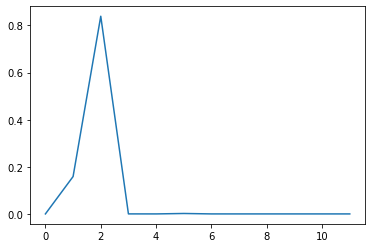

In [77]:
plt.plot(softmax(zwise[:,9]))

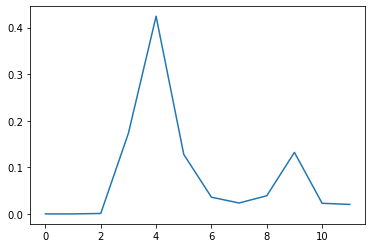

In [78]:
plt.plot(softmax(layerwise[:,9]))

In [5]:
raw_data.shape

(12, 63, 20)

In [13]:

x=example_layer[10]
boots=[]
for _ in range(10000):
    boots.append(np.median(np.random.choice(x,size=len(x),replace=True)))
print(np.percentile(boots,(2.5,97.5)),np.median(boots))

[ 9.84319749 19.25488374] 14.562590093922303


In [15]:
x=example_layer[10]
boots=[]
for _ in range(10000):
    boots.append(np.median(np.random.choice(x,size=len(x),replace=True)))
print(np.percentile(boots,(2.5,97.5)),np.median(boots))

[ 9.84319749 19.25488374] 14.562590093922303


In [17]:
rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC','HG','V1']
raw_data=np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_activations") for i in range(12)])
#raw_data=np.mean(np.asarray([raw_data[:,:,:10],raw_data[:,:,10:]]),axis=0)
example_layer=raw_data[9]
roi=[]
performance=[]
hemi=[]
for i in range(example_layer.shape[0]):
    for j in range(example_layer.shape[1]):
        roi.append(rois[j%11])
        hemi.append('L' if j<11 else 'R')
        r=example_layer[i,j]
        if r<-800:
            r=0
        performance.append(r)
roi=np.asarray(roi)
performance=np.asarray(performance)
hemi=np.asarray(hemi)
df=pd.DataFrame(dict(performance=performance,roi=roi,hemi=hemi))

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(-40, 80)

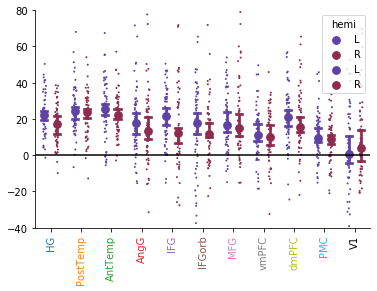

In [18]:
pal=sns.mpl_palette('tab10',n_colors=10)
pal2=sns.mpl_palette('twilight',n_colors=2)
#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
sns.stripplot(data=df,x='roi',y='performance',hue='hemi',dodge=0.4,zorder=1,size=2,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'])
sns.pointplot(data=df,x='roi',y='performance',hue='hemi',dodge=0.4,join=False,ci=95,n_boot=10000,capsize=0.2,zorder=2,alpha=0.5,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'],estimator=np.median)
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)
plt.xticks(rotation=90)
#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
plt.ylim(-40,80)

In [31]:
attention_concat=get_result_dataset(['black','slumlordreach'],'bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat')
attention_fwd=get_result_dataset(['black','slumlordreach'],'bert-base-uncased_syntactic_complexity_L-inf_T-128_D-fwd')
attention_bck=get_result_dataset(['black','slumlordreach'],'bert-base-uncased_syntactic_complexity_L-inf_T-128_D-bck')
attention_small=get_result_dataset(['black','slumlordreach'],'bert-base-uncased_syntactic_complexity_L-inf_T-20_D-concat')
ling_features=get_result_dataset(['black','slumlordreach'],'ling_features')

In [7]:
rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC','HG']
#rois=['HG','PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC']

roi_names=['L_'+roi for roi in rois]+['R_'+roi for roi in rois] 

In [7]:
attention_bck.shape

(63, 20)

In [15]:
bootstrap_pvalue(-1*np.ones((64,)))

1.0

In [32]:
def bootstrap_pvalue(data):
	shifted=data-np.mean(data)
	sampling=[]
	for _ in range(1000):
		m1=np.mean(np.random.choice(shifted[:42],replace=True,size=42))
		m2=np.mean(np.random.choice(shifted[42:],replace=True,size=17))
		sampling.append(np.mean([m1,m2]))
	sampling=np.asarray(sampling)
	p=np.sum(sampling>=np.mean(data))/len(sampling)
	return p
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]  

concat_fwd=p_adjust_bh([bootstrap_pvalue(attention_concat[:,i]-attention_fwd[:,i]) for i in range(20)])

concat_bck=p_adjust_bh([bootstrap_pvalue(attention_concat[:,i]-attention_bck[:,i]) for i in range(20)])
window=p_adjust_bh([bootstrap_pvalue(attention_concat[:,i]-attention_small[:,i]) for i in range(20)])
for i in range(20):
    print(roi_names[i],concat_fwd[i])



L_PostTemp 0.0
L_AntTemp 0.0
L_AngG 0.037142857142857144
L_IFG 0.07111111111111111
L_IFGorb 0.3858823529411765
L_MFG 0.943
L_vmPFC 0.3858823529411765
L_dmPFC 0.2290909090909091
L_PMC 0.016
L_HG 0.3858823529411765
R_PostTemp 0.0
R_AntTemp 0.0
R_AngG 0.3858823529411765
R_IFG 0.3858823529411765
R_IFGorb 0.8494736842105263
R_MFG 0.32833333333333337
R_vmPFC 0.118
R_dmPFC 0.07111111111111111
R_PMC 0.037142857142857144
R_HG 0.8494736842105263


In [33]:
for i in range(20):
    print(roi_names[i],concat_bck[i])

L_PostTemp 0.6933333333333334
L_AntTemp 0.44285714285714284
L_AngG 0.5575
L_IFG 0.8400000000000001
L_IFGorb 0.8400000000000001
L_MFG 0.295
L_vmPFC 0.6933333333333334
L_dmPFC 0.6933333333333334
L_PMC 0.8863157894736842
L_HG 0.0
R_PostTemp 0.6933333333333334
R_AntTemp 0.295
R_AngG 0.6363636363636364
R_IFG 0.42000000000000004
R_IFGorb 0.95
R_MFG 0.616
R_vmPFC 0.3
R_dmPFC 0.56
R_PMC 0.8400000000000001
R_HG 0.0


In [34]:
for i in range(20):
    print(roi_names[i],window[i])

L_PostTemp 0.052
L_AntTemp 0.14857142857142858
L_AngG 0.0
L_IFG 0.14666666666666667
L_IFGorb 0.9235294117647059
L_MFG 0.3383333333333334
L_vmPFC 0.41076923076923083
L_dmPFC 0.28500000000000003
L_PMC 0.0
L_HG 0.3383333333333334
R_PostTemp 0.3383333333333334
R_AntTemp 0.43
R_AngG 0.7306666666666667
R_IFG 0.986
R_IFGorb 0.986
R_MFG 0.3333333333333333
R_vmPFC 0.8925
R_dmPFC 0.04
R_PMC 0.02
R_HG 0.9355555555555556


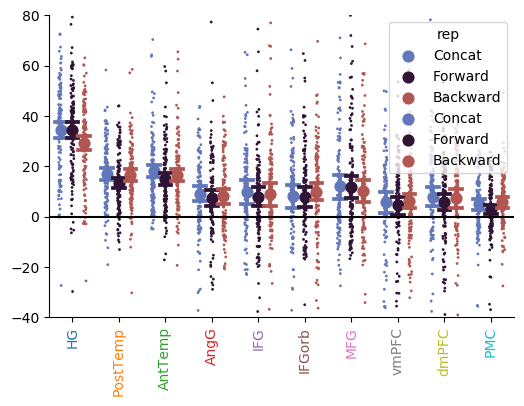

In [19]:

roi=[]
performance=[]
rep_name=[]
rep_names=['Concat','Forward','Backward']

reps=[attention_concat,attention_fwd,attention_bck]
p_values=[concat_fwd,concat_bck]
for k in range(3):
    example_layer=reps[k]
    for i in range(example_layer.shape[0]):
        for j in range(20):
            roi.append(rois[j%10])
            if k>0:
                if p_values[k][j]<.05:
                    rep_name.append(rep_names[k])
                else:
                    rep_name.append('Blank')
            else:
                

            r=example_layer[i,j]
            if r<-800:
                r=0
            performance.append(r)
roi=np.asarray(roi)
performance=np.asarray(performance)
rep_name=np.asarray(rep_name)
df=pd.DataFrame(dict(performance=performance,roi=roi,rep=rep_name))
plt.figure(dpi=100)
pal=sns.mpl_palette('tab10',n_colors=10)
pal2=sns.mpl_palette('twilight',n_colors=3)
#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
sns.stripplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,zorder=1,size=2,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC'])
sns.pointplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,join=False,ci=95,n_boot=10000,capsize=0.25,zorder=2,alpha=0.5,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC'])
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)
plt.xticks(rotation=90)
#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
#plt.legend([])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
plt.ylim(-40,80)
plt.savefig("plots/fig3_1/attention_direction.svg",format='svg')

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


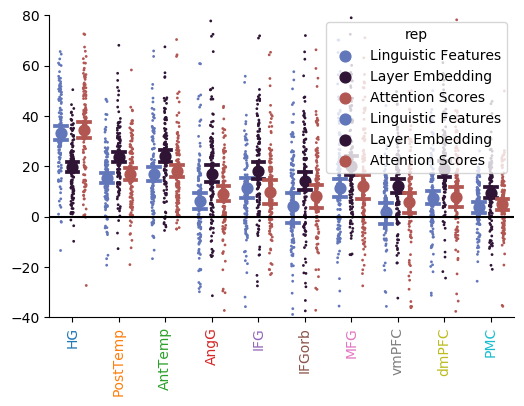

In [21]:
raw_data=np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_activations") for i in range(12)])

roi=[]
performance=[]
rep_name=[]
rep_names=['Linguistic Features','Layer Embedding','Attention Scores']
reps=[ling_features,raw_data[9],attention_concat]
for k in range(3):
    example_layer=reps[k]
    for i in range(example_layer.shape[0]):
        for j in range(20):
            roi.append(rois[j%10])
            rep_name.append(rep_names[k])
            r=example_layer[i,j]
            if r<-800:
                r=0
            performance.append(r)
roi=np.asarray(roi)
performance=np.asarray(performance)
rep_name=np.asarray(rep_name)
df=pd.DataFrame(dict(performance=performance,roi=roi,rep=rep_name))
plt.figure(dpi=100)
pal=sns.mpl_palette('tab10',n_colors=10)
pal2=sns.mpl_palette('twilight',n_colors=3)
#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
sns.stripplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,zorder=1,size=2,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC'])
sns.pointplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,join=False,ci=95,n_boot=10000,capsize=0.25,zorder=2,alpha=0.5,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC'])
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)
plt.xticks(rotation=90)
#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
#plt.legend([])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
plt.ylim(-40,80)
plt.savefig("plots/fig3_1/ling_features.svg",format='svg')

In [ ]:

roi=[]
performance=[]
rep_name=[]
rep_names=['Concat','Forward','Backward']
reps=[attention_concat,attention_fwd,attention_bck]
for k in range(3):
    example_layer=reps[k]
    for i in range(example_layer.shape[0]):
        for j in range(20):
            roi.append(rois[j%10])
            rep_name.append(rep_names[k])
            r=example_layer[i,j]
            if r<-800:
                r=0
            performance.append(r)
roi=np.asarray(roi)
performance=np.asarray(performance)
rep_name=np.asarray(rep_name)
df=pd.DataFrame(dict(performance=performance,roi=roi,rep=rep_name))
plt.figure(dpi=100)
pal=sns.mpl_palette('tab10',n_colors=10)
pal2=sns.mpl_palette('twilight',n_colors=3)
#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
sns.stripplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,zorder=1,size=2,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC'])
sns.pointplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,join=False,ci=95,n_boot=10000,capsize=0.25,zorder=2,alpha=0.5,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC'])
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)
plt.xticks(rotation=90)
#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
#plt.legend([])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
plt.ylim(-40,80)
plt.savefig("plots/fig3_1/attention_direction.svg",format='svg')

In [5]:
raw_data=np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_activations") for i in range(12)])
raw_data.shape

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(12, 63, 20)

In [9]:
raw_data=np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_activations") for i in range(12)])

roi=[]
performance=[]
#hemi=[]
layers=[]
for layer_number in range(12):
    example_layer=raw_data[layer_number]
    for i in range(example_layer.shape[0]):
        for j in range(11):
            roi.append(rois[j%10]+"_"+str(layer_number))
            #hemi.append('L' if j<10 else 'R')
            r=example_layer[i,j]
            if r<-800:
                r=0
            performance.append(r)

roi=np.asarray(roi)
performance=np.asarray(performance)
#hemi=np.asarray(hemi)
df=pd.DataFrame(dict(performance=performance,roi=roi))
plt.figure(figsize=(50,9))
colors=list(sns.mpl_palette('tab10',n_colors=10).as_hex())+['#000000']
pal=sns.color_palette(colors)
pal2=sns.mpl_palette('twilight',n_colors=2)
roi_order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1']
order=[]
for roi in roi_order:
    for layer_number in range(12):
        order.append(roi+"_"+str(layer_number))
    
#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
sns.stripplot(data=df,x='roi',y='performance',dodge=0.4,zorder=1,size=2,order=order)
sns.pointplot(data=df,x='roi',y='performance',hue='roi',dodge=0.4,join=False,ci=95,n_boot=10000,capsize=0,zorder=2,alpha=0.5,palette=pal,order=order)
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)

#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
#plt.legend([])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=[]
tick_labels=[]
for i in range(10):
    my_colors+=["C"+str(i) for _ in range(12)]
    tick_labels+=["Layer "+str(j) for j in range(12)]

plt.xticks(ticks=list(range(len(tick_labels))),labels=tick_labels,rotation=90)

idx=0
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
    idx+=1
plt.xlabel("") 
plt.ylabel("")
plt.ylim(-40,80)
plt.savefig('plots/fig1_2/full_roi_layers.svg',format='svg')

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


KeyboardInterrupt: 